# LT-DSC-Skript


## required libraries 

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from ltdsc_lib import *

Wähle manuell die relevanten Segmentpositionen aus in Form einer Liste. Z.B für Segment 6-8 und 14-16:

`measure_segments = [[6,8],[14,16]]`

In [2]:
measure_segments =  [ [6,8],
                      [14,16] ]

thaw_temp_range  =  [ [-16, 10], 
                      [-57, 10] ] # in °C
T_range = [[[-21.5,-20.5], [9,10]], [[-57,-56], [9,10]]]

## select a single measurement

  Found a valid experiment file. Encoding: ISO-8859-1
  Loading C2S_21d-3
    - loaded measurement C2S_21d-3 from 2024-11-28 15:02:00
    - The data contains 5.0 measurements per s


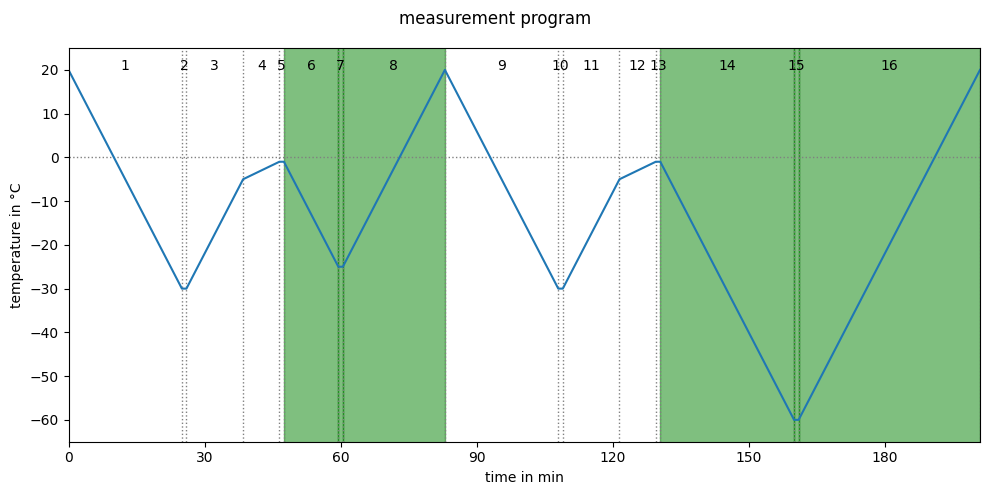

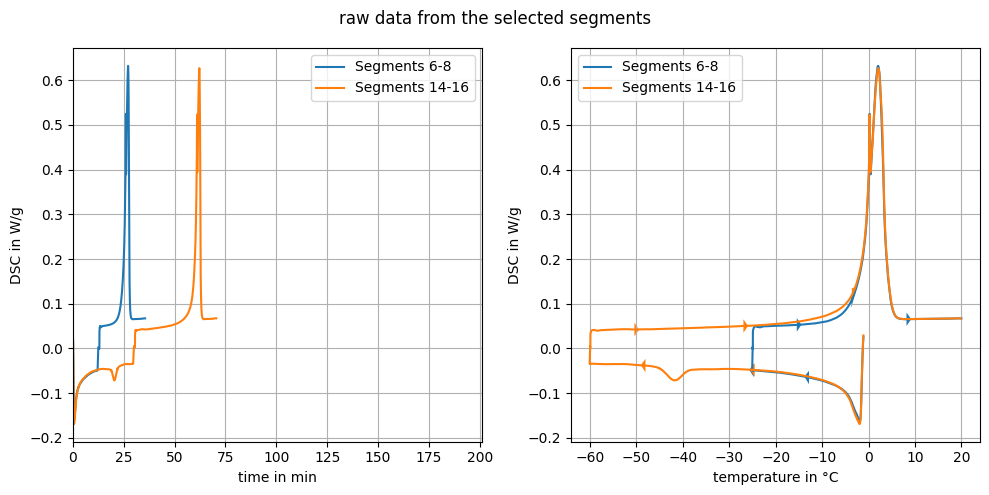

  Segment 8 baseline: y = 0.00101684*x + 0.04807089; R-squared value: 0.99986381
  Segment 16 baseline: y = 0.00074062*x + 0.03999178; R-squared value: 0.99997605


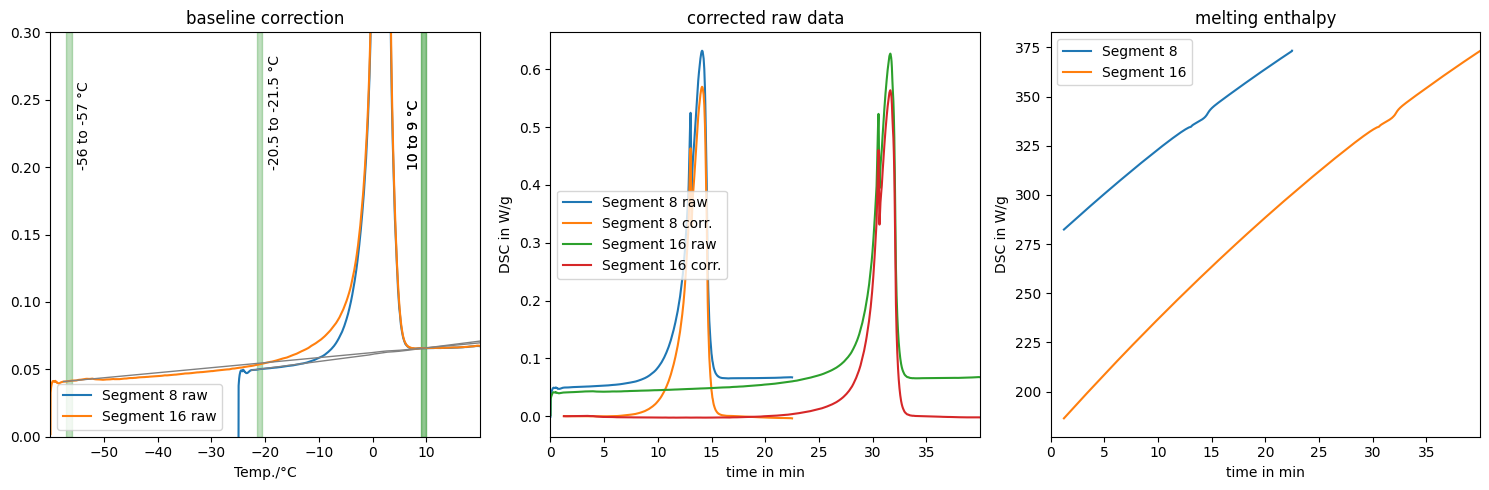

  (manual) ice mass/volume in segment 08 between [-21.5, -20.5] to [9, 10] and [-57, -56] to [9, 10] °C: 217.4 mg/g ; 237.2 µl/g
  (manual) ice mass/volume in segment 16 between [-21.5, -20.5] to [9, 10] and [-57, -56] to [9, 10] °C: 230.7 mg/g ; 251.6 µl/g


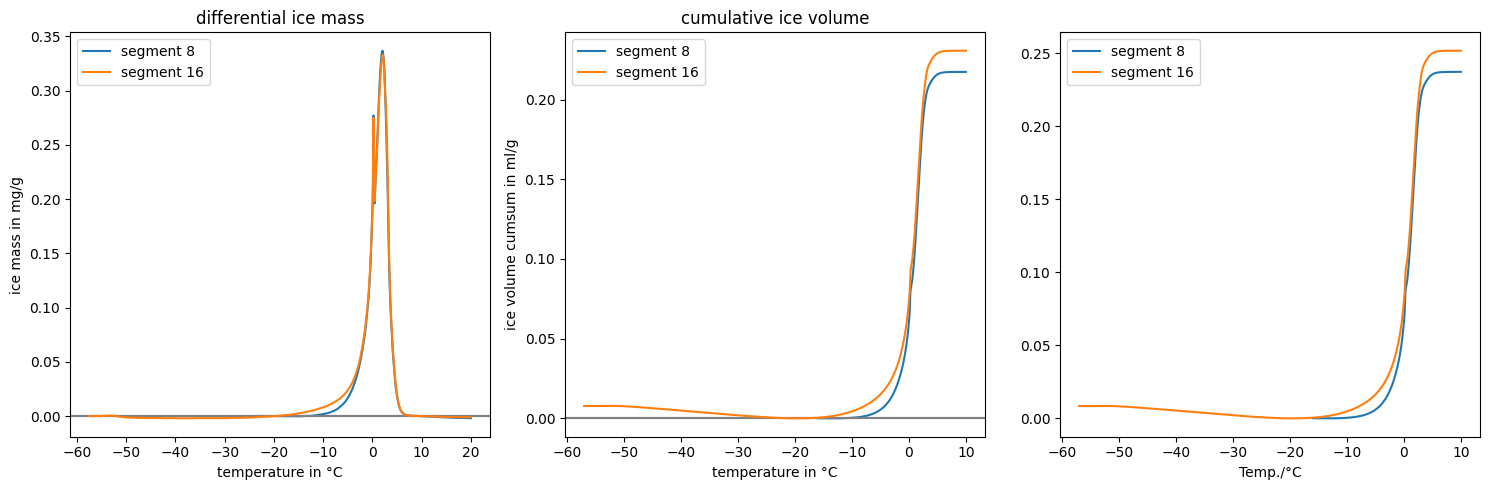

  ice mass difference: 13.28 mg/g


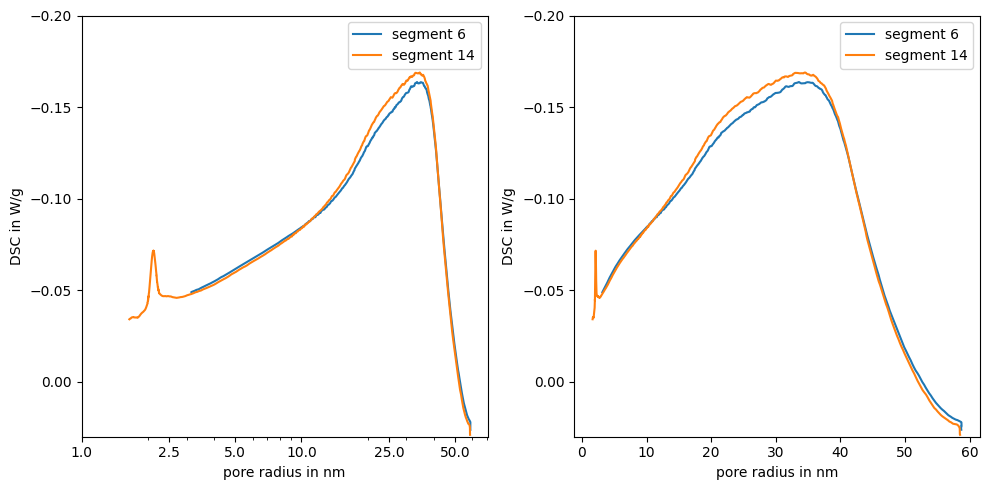

In [3]:
file = select_single_file()
experiment = ltdsc_measurement(file, measure_segments, thaw_temp_range, ignore_first_n_min = 1.25, T_range = T_range, verbose=True)

## The following code is individual for the selected dataset

In [4]:
directory, materials = load_multiple_experiments( measure_segments, thaw_temp_range, T_range )
specimen_ages = ['1d','7d','14d','21d','28d']
ice_dataframe, ice_stat_dataframe, ice_dataframe_2, ice_stat_dataframe_2 = process_ice_mass_dev( materials, specimen_ages )

27 TXT Dokumente gefunden.

ExpDat_C2S_14d-1.txt
  Found a valid experiment file. Encoding: ISO-8859-1
  Loading C2S_14d-1
    - loaded measurement C2S_14d-1 from 2024-11-21 07:59:00
    - The data contains 5.0 measurements per s
  Segment 8 baseline: y = 0.00111144*x + 0.04818897; R-squared value: 0.99986594
  Segment 16 baseline: y = 0.00078298*x + 0.04052682; R-squared value: 0.99992253
  (manual) ice mass/volume in segment 08 between [-21.5, -20.5] to [9, 10] and [-57, -56] to [9, 10] °C: 237.8 mg/g ; 259.4 µl/g
  (manual) ice mass/volume in segment 16 between [-21.5, -20.5] to [9, 10] and [-57, -56] to [9, 10] °C: 246.4 mg/g ; 268.8 µl/g
  ice mass difference: 8.57 mg/g

ExpDat_C2S_14d-2.txt
  Found a valid experiment file. Encoding: ISO-8859-1
  Loading C2S_14d-2
    - loaded measurement C2S_14d-2 from 2024-11-21 11:30:00
    - The data contains 5.0 measurements per s
  Segment 8 baseline: y = 0.00124106*x + 0.04589629; R-squared value: 0.99934537
  Segment 16 baseline: y = 0.000

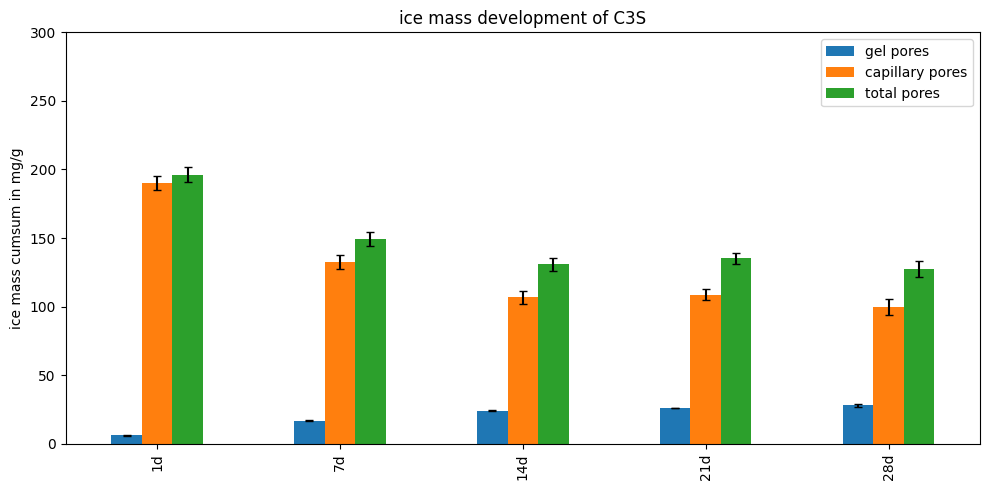

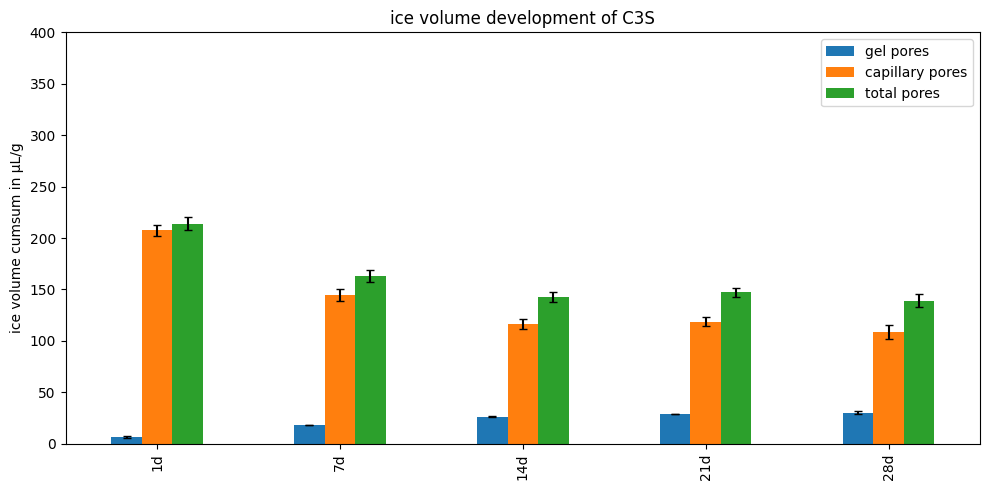

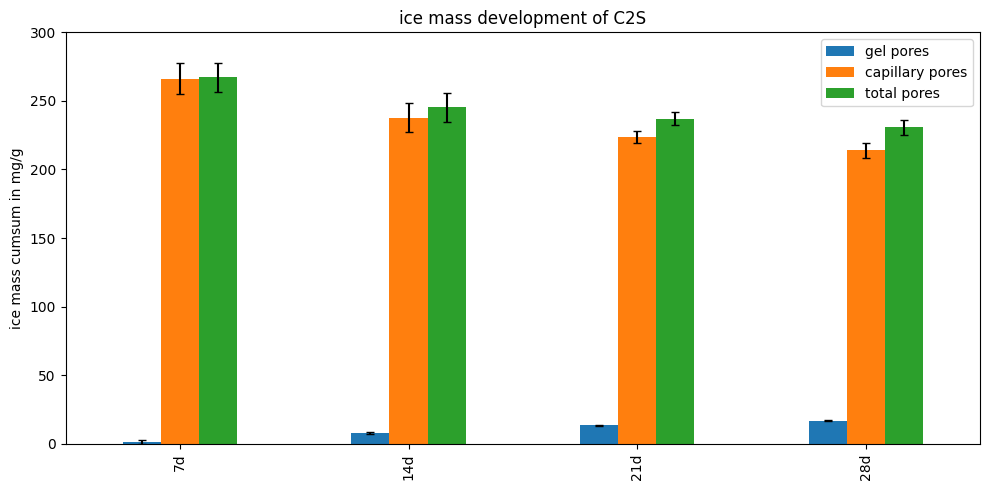

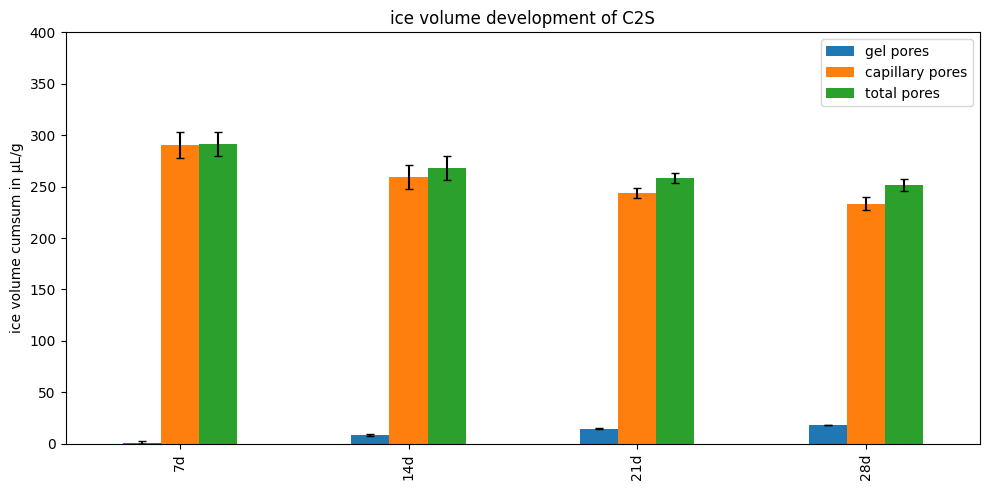

In [5]:
material_list = ['C3S', 'C2S']
for material_key in material_list:
    plot_ice_mass_development(material_key, ice_stat_dataframe, directory )
    plot_ice_vol_development(material_key, ice_stat_dataframe_2, directory )

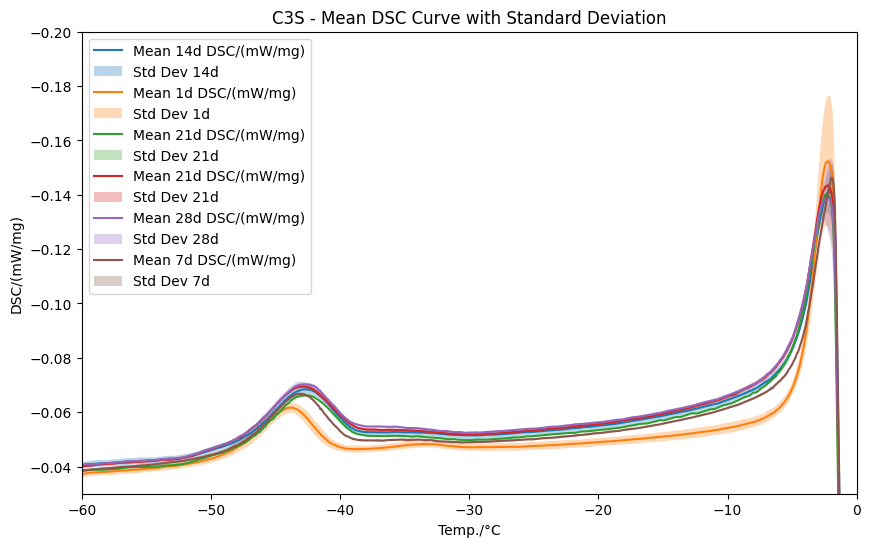

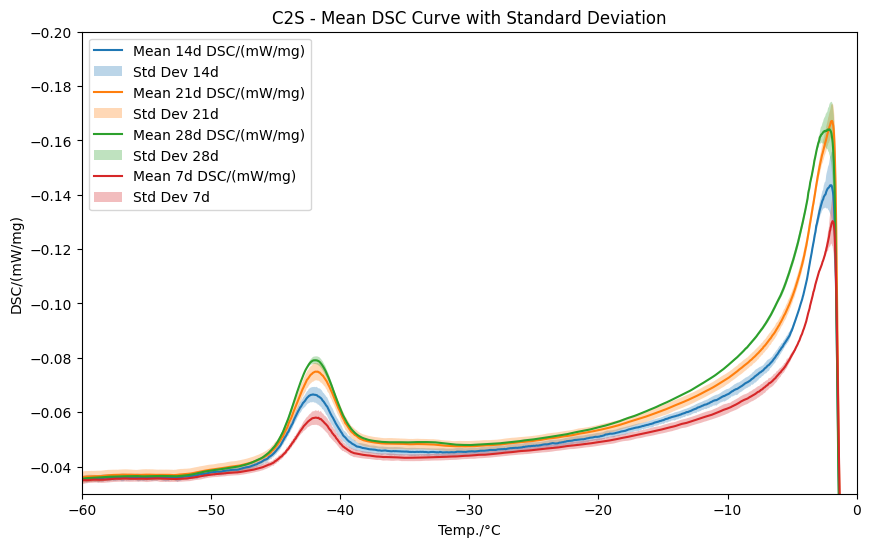

In [6]:
mean_dataframes_dict = {}
for material_key in material_list:
    dataframes = {}
    for key, experiment in materials[material_key].items():
        if not key[:-2] in dataframes.keys(): dataframes[key[:-2]] = []
        df_s = experiment.raw_data[(experiment.raw_data['Segment'] == 14)]
        dataframes[key[:-2]].append(  df_s.iloc[::int(experiment.values_per_s)][['Temp./°C', 'DSC/(mW/mg)', 'pore radius in nm']] )
        
    mean_dataframes = {}
    plt.figure(figsize=(10, 6))
    for key, exp_groups in dataframes.items():
        # Define the common temperature range
        common_temp = np.linspace(min(df['Temp./°C'].min() for df in exp_groups),
                                max(df['Temp./°C'].max() for df in exp_groups), num=2000)

        # Initialize arrays to store the interpolated DSC values and their squares
        mean_dsc = np.zeros_like(common_temp)
        std_dsc = np.zeros_like(common_temp)

        # Interpolate the DSC values to the common temperature range and calculate the mean and std
        for df in exp_groups:
            interp_dsc = np.interp(common_temp, list(reversed(df['Temp./°C'].to_list())), list(reversed(df['DSC/(mW/mg)'].to_list())))
            #plt.plot(common_temp, interp_dsc, label='DSC/(mW/mg)')
            mean_dsc += interp_dsc
            std_dsc += interp_dsc**2

        mean_dsc /= len(exp_groups)
        std_dsc = np.sqrt(std_dsc / len(exp_groups) - mean_dsc**2)

        # Create a new dataframe with the common temperature range, mean DSC values, and standard deviation
        df_mean_dsc = pd.DataFrame({'Temp./°C': common_temp, 'DSC_mean/(mW/mg)': mean_dsc, 'DSC_std/(mW/mg)': std_dsc})
        
        df_mean_dsc['pore radius in nm'] = df_mean_dsc.apply(
            lambda row:  get_brun_pore_radius( row['Temp./°C'], 'freeze', True ),
            axis=1 # this returns a single row
        )
        
        mean_dataframes[key] = df_mean_dsc 
        df_mean_dsc.to_csv(os.path.dirname(experiment.filepath) + os.sep +'{}_mean_freeze_segment.csv'.format(key), index=False)

        plt.plot(common_temp, mean_dsc, label='Mean {} DSC/(mW/mg)'.format(key[4:]))
        plt.fill_between(common_temp, mean_dsc - std_dsc, mean_dsc + std_dsc, alpha=0.3, label='Std Dev {}'.format(key[4:]))
        
    mean_dataframes_dict[material_key] = mean_dataframes
    
    plt.xlabel('Temp./°C')
    plt.ylabel('DSC/(mW/mg)')
    plt.xlim(-60, 0)
    plt.ylim(-0.03,-.20)
    plt.title('{} - Mean DSC Curve with Standard Deviation'.format(material_key))
    plt.legend()
    plt.show()

C3S_14d: -0.06147557946019022 + -0.0003443307156064616 x
C:/Users/Florian Kleiner/Nextcloud/Uni/WdB/Paper/2024 LT-DSC-XRD-BSE Alit-Belit Paper/LTDSC-neu\C3S_14d_mean_freeze_segment.csv
C3S_1d: -0.05400757617963872 + -0.0002555256723039064 x
C:/Users/Florian Kleiner/Nextcloud/Uni/WdB/Paper/2024 LT-DSC-XRD-BSE Alit-Belit Paper/LTDSC-neu\C3S_1d_mean_freeze_segment.csv
C3S 21d: -0.06051190333170793 + -0.0003685362303392471 x
C:/Users/Florian Kleiner/Nextcloud/Uni/WdB/Paper/2024 LT-DSC-XRD-BSE Alit-Belit Paper/LTDSC-neu\C3S 21d_mean_freeze_segment.csv
C3S_21d: -0.0624434042409435 + -0.00036293487335170804 x
C:/Users/Florian Kleiner/Nextcloud/Uni/WdB/Paper/2024 LT-DSC-XRD-BSE Alit-Belit Paper/LTDSC-neu\C3S_21d_mean_freeze_segment.csv
C3S_28d: -0.06353048850534222 + -0.0003787698056193136 x
C:/Users/Florian Kleiner/Nextcloud/Uni/WdB/Paper/2024 LT-DSC-XRD-BSE Alit-Belit Paper/LTDSC-neu\C3S_28d_mean_freeze_segment.csv
C3S_7d: -0.0576174700353571 + -0.0002968229522303067 x
C:/Users/Florian Klein

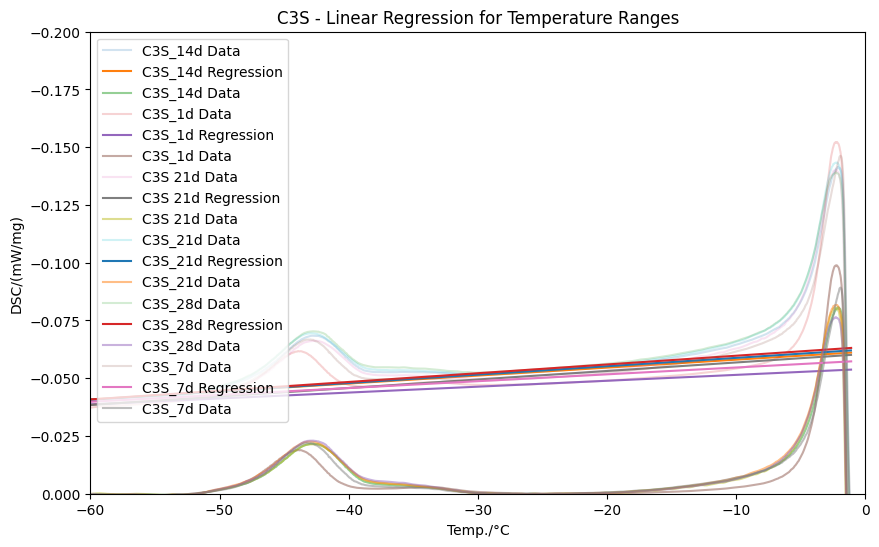

C2S_14d: -0.05788258543342016 + -0.000409304960711311 x
C:/Users/Florian Kleiner/Nextcloud/Uni/WdB/Paper/2024 LT-DSC-XRD-BSE Alit-Belit Paper/LTDSC-neu\C2S_14d_mean_freeze_segment.csv
C2S_21d: -0.060633144860307374 + -0.0004428907087216476 x
C:/Users/Florian Kleiner/Nextcloud/Uni/WdB/Paper/2024 LT-DSC-XRD-BSE Alit-Belit Paper/LTDSC-neu\C2S_21d_mean_freeze_segment.csv
C2S_28d: -0.062006915955847314 + -0.0004775220042263281 x
C:/Users/Florian Kleiner/Nextcloud/Uni/WdB/Paper/2024 LT-DSC-XRD-BSE Alit-Belit Paper/LTDSC-neu\C2S_28d_mean_freeze_segment.csv
C2S_7d: -0.05547380303844134 + -0.0003739767621588531 x
C:/Users/Florian Kleiner/Nextcloud/Uni/WdB/Paper/2024 LT-DSC-XRD-BSE Alit-Belit Paper/LTDSC-neu\C2S_7d_mean_freeze_segment.csv


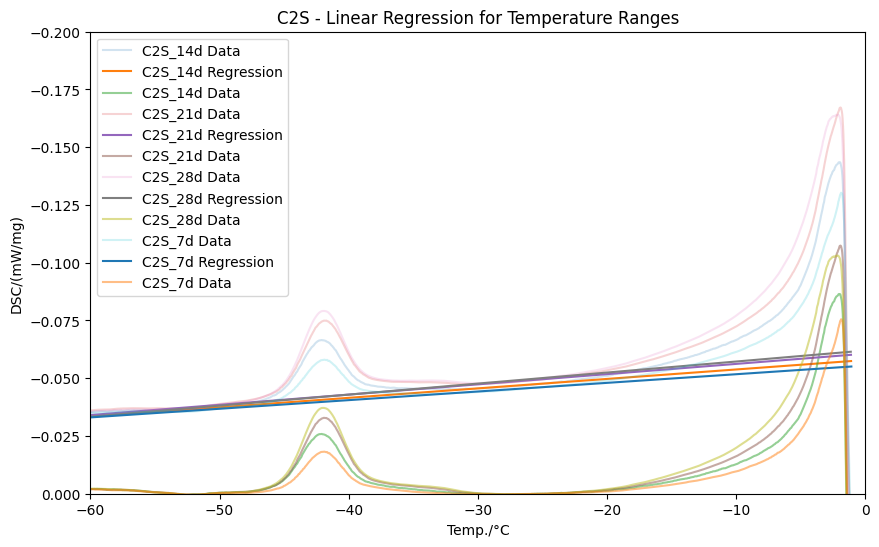

In [7]:
for m in material_list:
    # Define the temperature ranges for the linear regression
    temp_ranges = [[-55, -50], [-27, -23]]

    # Initialize a dictionary to store the regression results
    regression_results = {}

    plt.figure(figsize=(10, 6))
    # Loop through each material and its corresponding dataframes
    for material_key, df in mean_dataframes_dict[m].items():
        
        #for temp_range in temp_ranges:
        # Initialize lists to store the temperature and DSC values within the range
        temp_values = []
        dsc_values = []
        
        # Filter the dataframe based on the temperature range
        df_filtered = df[((df['Temp./°C'] >= temp_ranges[0][0]) & (df['Temp./°C'] <= temp_ranges[0][1]) | (df['Temp./°C'] >= temp_ranges[1][0]) & (df['Temp./°C'] <= temp_ranges[1][1]))]
        temp_values.extend(df_filtered['Temp./°C'].values)
        dsc_values.extend(df_filtered['DSC_mean/(mW/mg)'].values)
        
        # Perform linear regression
        X = np.array(temp_values).reshape(-1, 1)
        y = np.array(dsc_values)
        model = LinearRegression()
        model.fit(X, y)
        df['fit'] = model.predict(np.array(df['Temp./°C'].values).reshape(-1, 1))
        df['DSC_corr/(mW/mg)'] = df['DSC_mean/(mW/mg)']-df['fit']
        print("{}: {} + {} x".format(material_key, model.intercept_, model.coef_[0]))
        
        # Store the regression results
        regression_results[f"{material_key}"] = model

        # Plot the original data points
        plt.plot(df['Temp./°C'], df['DSC_mean/(mW/mg)'], label=f'{material_key} Data', alpha=0.2)
        
        # Plot the regression line
        plt.plot(df['Temp./°C'], df['fit'], label=f'{material_key} Regression')

        plt.plot(df['Temp./°C'], df['DSC_corr/(mW/mg)'], label=f'{material_key} Data', alpha=0.5)
        
        df = df.drop('fit', axis=1)
        df.to_csv(os.path.dirname(experiment.filepath) + os.sep +'{}_mean_freeze_segment.csv'.format(material_key), index=False)
        print(os.path.dirname(experiment.filepath) + os.sep +'{}_mean_freeze_segment.csv'.format(material_key))
    plt.xlabel('Temp./°C')
    plt.ylabel('DSC/(mW/mg)')
    plt.xlim(-60, 0)
    plt.ylim(0,-.20)
    plt.title(f'{m} - Linear Regression for Temperature Ranges')
    plt.legend()
    plt.show()